# Mixup & CutMix Augmentations

In [1]:
#hide
%load_ext autoreload
%autoreload 2

`timm` supports a wide variety of augmentations and one such augmentation is [Mixup](https://arxiv.org/abs/1710.09412). [CutMix](https://arxiv.org/abs/1905.04899) followed Mixup and most deep learning practitioners use either Mixup or CutMix in their training pipelines to improve performance. 

**BUT** with `timm` there is an option to use both! In this tutorial we will be looking specifically into the various training arguments to implement `MixUp` and `CutMix` augmentations during training and also look into the internals of the library to see how this is achieved in `timm`.

## Training Neural Networks with Mixup/Cutmix Augmentations

The various training arguments that are of interest when applying `Mixup`/`CutMix` data augmentations are:

```markdown
--mixup MIXUP         mixup alpha, mixup enabled if > 0. (default: 0.)
--cutmix CUTMIX       cutmix alpha, cutmix enabled if > 0. (default: 0.)
--cutmix-minmax CUTMIX_MINMAX [CUTMIX_MINMAX ...]
                    cutmix min/max ratio, overrides alpha and enables
                    cutmix if set (default: None)
--mixup-prob MIXUP_PROB
                    Probability of performing mixup or cutmix when
                    either/both is enabled
--mixup-switch-prob MIXUP_SWITCH_PROB
                    Probability of switching to cutmix when both mixup and
                    cutmix enabled
--mixup-mode MIXUP_MODE
                    How to apply mixup/cutmix params. Per "batch", "pair",
                    or "elem"
--mixup-off-epoch N   Turn off mixup after this epoch, disabled if 0. (default: 0.)
```

### Only Mixup

To train a network with only mixup enabled, simply pass in the `--mixup` argument with a probability of augmentation. 

```python
python train.py ../imagenette2-320 --mixup 0.7
```

### Only CutMix

To train a network only CutMix enabled, simply pass in the `--cutmix` argument with a probability of augmentation. 

```python
python train.py ../imagenette2-320 --cutmix 0.2
```

### Both Mixup and Cutmix

To train a nueral network with both enabled, 

```python
python train.py ../imagenette2-320 --cutmix 0.4 --mixup 0.5
```

When both Mixup and CutMix are enabled, then for each batch, `timm` either 

## Visualizing Mixup & Cutmix

Internally, the `timm` library has a class called `Mixup` that is capable of impementing both Mixup and Cutmix. 

In [2]:
import torch
from timm.data.mixup import Mixup
from timm.data.dataset import ImageDataset
from timm.data.loader import create_loader

In [3]:
def get_dataset_and_loader(mixup_args):
    mixup_fn = Mixup(**mixup_args)
    dataset = ImageDataset('../../imagenette2-320')
    loader = create_loader(dataset, 
                           input_size=(3,224,224), 
                           batch_size=4, 
                           is_training=True, 
                           use_prefetcher=False)
    return mixup_fn, dataset, loader

### Visualize a few images with `Mixup`

In [4]:
import torchvision
import numpy as np
from matplotlib import pyplot as plt

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
# only mixup    
mixup_args = {
    'mixup_alpha': 1.,
    'cutmix_alpha': 0.,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 1000}

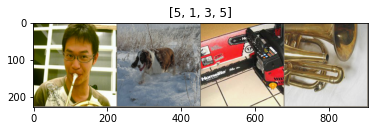

In [7]:
# Get a batch of training data
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

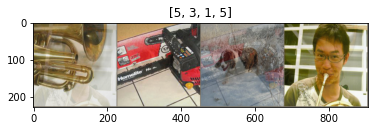

In [8]:
# display data after mixup 
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

### Visualize a few images with `Cutmix`

In [9]:
# only cutmix    
mixup_args = {
    'mixup_alpha': 0.,
    'cutmix_alpha': 1.0,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 1000}

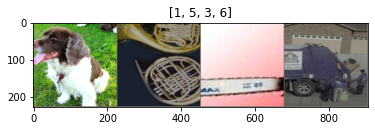

In [10]:
# Get a batch of training data
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

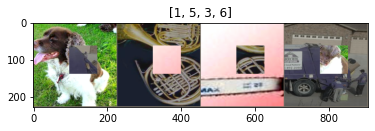

In [11]:
# display data after CutMix
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

## What is Mixup doing internally?

In [10]:
def mixup(x, lam):
    """Applies mixup to input batch of images `x`
    
    Args:
    x (torch.Tensor): input batch tensor of shape (bs, 3, H, W)
    lam (float): Amount of MixUp
    """
    x_flipped = x.flip(0).mul_(1-lam)
    x.mul_(lam).add_(x_flipped)
    return x

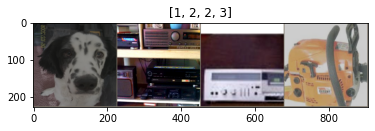

In [17]:
# Get a batch of training data
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

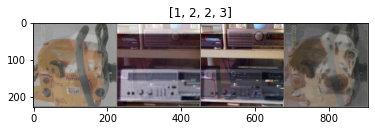

In [18]:
imshow(
    torchvision.utils.make_grid(
        mixup(inputs, 0.3)
    ), 
    title=[x.item() for x in classes])

## Element-wise Mixup/Cutmix

It is also possible to do elementwise Mixup/Cutmix in `timm`. As far as I know, this is the only library that allows for element wise Mixup and Cutmix! 

Until now, all operations were applied batch-wise. That is Mixup was done for all elements in a batch. But, by passing argument `mode = 'elem'` to the `Mixup` function, we can change it to be elementwise. 

In this case, `Cutmix` or `Mixup` is applied to each item inside the batch based on the `mixup_args`. 

As can be seen below, Cutmix is being applied to the first, second and third item in the batch, whereas mixup is being applied to the fourth item. 

In [26]:
# only mixup    
mixup_args = {
    'mixup_alpha': 0.3,
    'cutmix_alpha': 0.3,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.5,
    'mode': 'elem',
    'label_smoothing': 0,
    'num_classes': 1000}

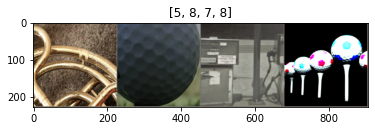

In [27]:
# Get a batch of training data
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

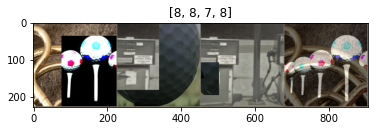

In [28]:
# display data after mixup 
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])